In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sys import maxsize

### Setup

In [18]:
# DATA EXTRACTION
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
    'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    'due_date': [None, None, None, None, None, None, None, None, 50.0, None, None, None, None, None, 80.0, None, None, None, None, 30.0, None],
    'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8],
    'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'],
    'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"]
})
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2", "WC#3"],
    'M1': [3, 2, 3],
    'M2': [2, 1, 2],
    'M3': [1, 2, 1],
    'M4': [1, 1, 1],
    'M5': [1, 2, 3]
})
display(df_BOM)
display(df_machine)

class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = id
        self.machines = dict_machines
        # dict_machines = {'M1': [ [], [], [] ] }
        # this means that there are 3 M1 machines
        # the [] nested inside the list refers to the usage timings of the i-th M1 machine
        # for example: [ [(0,3), (4,5)], [], []]
        # means that the 1st machine is used from (0,3) and (4,5)

# class Operation:
#     def __init__(self, id, processing_time, workcenter, machine, due_date=None, successors=None):
#         self.id = id
#         # Precedence constraints
#         self.successors = successors if successors else []
#         # self.predecessors = predecessors if predecessors else []
#         # Workcenter and machine information
#         self.workcenter = workcenter
#         self.machine = machine

#         # Times
#         self.processing_time = processing_time
#         self.start_time = None
#         self.end_time = None
#         self.due_date = None if due_date != due_date else due_date

#         # Other
#         self.scheduled = False

factory = {}
for idx, row in df_machine.iterrows():
    workcenter = row['workcenter']
    dict_machines = {}
    for machine in (df_machine.columns[1:]): 
        dict_machines[machine] = [[] for _ in range(row[machine])]
    # factory.append(WorkCenter(workcenter, dict_machines=dict_machines))
    factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,A,[],0,NaN,3,WC#2,M1
1,B,[],0,NaN,2,WC#1,M2
2,C,[A],0,NaN,1,WC#1,M3
3,D,[B],0,NaN,3,WC#2,M2
4,E,"[C, D]",0,NaN,1,WC#2,M4
5,F,"[E, G]",0,NaN,3,WC#2,M5
6,G,[H],0,NaN,5,WC#2,M1
7,H,[],0,NaN,7,WC#3,M2
8,I,[F],1,50.0,4,WC#2,M3
9,J,[],0,NaN,18,WC#1,M4


,workcenter,M1,M2,M3,M4,M5
0,WC#1,3,2,1,1,1
1,WC#2,2,1,2,1,2
2,WC#3,3,2,1,1,3


### Functions

In [19]:
def find_critical_path(operations, operation_ids):
    """
    Finds the critical path among the feasible operations.
    Inputs:
        - operations                    : dictionary {operation_id: Operation()}, a dictionary of all operations.
        - operation_ids                 : list[operation_id],  a list of operation IDs that are currently feasible.
    Output:
        - (critical_path, path_length)  : tuple, containing the critical path (list of operation IDs) and the length of the critical path.
    """

    paths = []
    def dfs(operation_id, current_path, current_length):
        """
        Performs depth-first-search in a given operation network using recursion.
        Inputs: 
            - operation_id          : str, id of the operation to begin DFS at
            - current_path          : list [str], The path of operation IDs visited so far
            - current_length        : float - The cumulative processing time along the current path
        Output:
            - None - The function modifies the 'paths' list in place, adding tuples of (path, length) for each terminal path found.
        Explanation:
            - This function recursively traverses the operation network starting from the given operation_id.
            - It explores all successors of the current operation, appending the current operation to the path and adding its processing time to the cumulative length.
            - If an operation has no successors, it adds the complete path and its length to the 'paths' list.
        """

        operation = operations[operation_id]
        # If the operation has a successor, add to path
        # Otherwise, perform forward recursive DFS on each of the operation's successor to explore all possible paths
        if not operation.successors: # if the operation does not have any successor
            paths.append((current_path + [operation_id], current_length + operation.processing_time))
        else:
            for succ_id in operation.successors:
                dfs(succ_id, current_path + [operation_id], current_length + operation.processing_time)

    # For every operation, perform DFS
    for op_id in operation_ids:
        dfs(op_id, [], 0)
    print(f"paths: {paths}")
    return max(paths, key=lambda x: x[1])

def schedule_operations(operations, due_dates, factory):
    """
    Solves the assembly scheduling problem (ASP) using the Longest End Time Scheduling Algorithm (LETSA).
    Inputs:
        - operations            : dictionary {operation_id: Operation()}, a dictionary of all operations.
        - due_dates             : dictionary {operation_id: int}, a dictionary of due dates for each operation.
        - factory               : list [WorkCenter()], a list of WorkCenter objects, containing machine information and availability
    Output:
        - scheduled_operations  : list [Operation()], a list of Operation objects with start and end time schedules.
    """

    scheduled_operations = []
    # [[Step 4]]
    while True:
        # ================================================================================================================
        #  [[4.0]] Feasible operations = every operation that is (1) not scheduled, and (2) has all successors scheduled
        # ================================================================================================================
        feasible_operations = [op_id for op_id, op in operations.items() if not op.scheduled and all(operations[succ_id].scheduled for succ_id in op.successors)]
        print(f"feasible operations: {feasible_operations}")
        if not feasible_operations:
            break # terminate if all operations have been scheduled

        # ===================================================================
        #  [[4.1 - 4.3]] Compute critical path only for feasible operations
        # ===================================================================
        critical_path, length = find_critical_path(operations, feasible_operations)
        print(f"critical path: {critical_path}, length: {length}")
        operation_id = critical_path[0]
        operation = operations[operation_id]
        print(operation_id)

        # =====================================================================
        # [[4.4]] Set completion/end time of the selected operation as
        #         (ii) the start time of the successor, if a successor exists
        #         (ii) the project deadline, otherwise 
        # =====================================================================
        if operation.successors: # if the operation has successors 
            # then the tentative end time is the earliest / min of the start time of all successors
            tentative_end_time = min(operations[succ_id].start_time for succ_id in operation.successors)
        else: 
            # else, the operation is an end product and its completion time must be its deadline
            tentative_end_time = due_dates[operation.id]

        # ============================================================================
        #   [[4.5]] For each identical machine incuded in the required work-center 
        # ============================================================================
        current_workcenter_id = operation.workcenter
        current_workcenter = factory[current_workcenter_id]             # WorkCenter object 
        machine_type = operation.machine                                # machine id of required machine
        possible_machines = current_workcenter.machines[machine_type]   # [[], [], []]

        earliest_start_time = float('inf')
        selected_machine = None
        for machine_idx, machine_schedule in enumerate(possible_machines):
            print(machine_idx, machine_schedule)
            if not machine_schedule:  # If machine schedule is empty, then machine is immediately useable
                available_start_time = 0
            else:
                # available_start_time = machine_schedule[-1][1]  # Get the end time of the last scheduled operation on this machine
                available_start_time = machine_schedule[0][1]  # Get the end time of the last scheduled operation on this machine

            if available_start_time < earliest_start_time:
                earliest_start_time = available_start_time
                selected_machine = machine_schedule

        # ============================================================================
        #   [[4.6]] Schedule the operation Jc at the latest available starting time 
        # ============================================================================
        start_time = min(earliest_start_time, tentative_end_time - operation.processing_time)
        end_time = start_time + operation.processing_time

        operation.start_time = start_time
        operation.end_time = end_time
        operation.scheduled = True
        selected_machine.append((start_time, end_time))
        scheduled_operations.append(operation)
        
    return scheduled_operations

def plot_gantt_chart(scheduled_operations):
    """
    Plots a Gantt chart for the scheduled operations.
    Inputs:
        - scheduled_operations      : list Operation(), a list of scheduled Operation objects.
    Output:
        - None 
        - Displays a Gantt chart.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    for op in scheduled_operations:
        ax.barh(op.id, op.processing_time, left=op.start_time, color='skyblue')
        ax.text(op.start_time + op.processing_time / 2, op.id, f'{op.start_time}-{op.end_time}', ha='center', va='center', color='black')

    ax.set_xlabel('Time')
    ax.set_ylabel('Operations')
    ax.set_title('Gantt Chart for Assembly Scheduling')
    plt.grid(True)
    plt.show()

def load_operations_from_df(df):
    """
    Loads operations from a DataFrame and creates Operation objects.    
    Inputs:
        - df: pandas DataFrame - A DataFrame containing BOM information with columns 
          ['part', 'operation', 'operation_id', 'components_required', 'processing_time', 'workcenter', 'predecessor_operations'].
    Output:
        - operations: dictionary, {operation_id: Operation()} - A dictionary of Operation objects.
    """
    # operations = {}
    # for idx, row in df.iterrows():
    #     # print(row)
    #     operation_id = row['operation']
    #     print(operation_id)
    #     successors = row['predecessor_operations']
    #     print(f"successors: {successors}")
    #     due_date = row['due_date']  
    #     the_operation = Operation(operation_id, row['processing_time'], row['workcenter'], row['machine'], due_date=due_date, successors=successors)
    #     # print(the+_opera)
    #     operations[operation_id] = the_operation 
        
    # return operations # this code is wrong!!!!!

    operations = {}

    for index, row in df.iterrows():
        op = Operation(
            id=row['operation'],
            processing_time=row['processing_time'],
            workcenter=row['workcenter'],
            machine=row['machine'],
            due_date=row['due_date'],
            predecessors=row['predecessor_operations']
        )
        operations[op.id] = op

    for index, row in df.iterrows():
        current_op_id = row['operation']
        predecessor_ops = row['predecessor_operations']
        for predecessor in predecessor_ops:
            operations[predecessor].successors.append(current_op_id)
    
    return operations



def load_due_dates(df):
    """
    Generates due dates for each operation.    
    Inputs:
        - df: pandas DataFrame - A DataFrame containing BOM information.
    Output:
        - due_dates: dictionary, {operation_id: int} - A dictionary of due dates for each operation.
    """
    due_dates = {}
    for idx, row in df.iterrows():
        operation_id = row['operation']
        # Example due date assignment, this should be adjusted as per actual due dates
        due_dates[operation_id] = 20 - idx  # Example: descending due dates
    return due_dates


In [21]:
# # EXPERIMENTATION
# # dict_successors = {
# #     'A': 'D', 'B': 'D', 'C':'E'
# # }
# # operations = {}
# # for operation_id in feasible_operations: 
# #     operations[operation_id] = Operation(operation_id, 3, '1', '2', due_date=30, successors=dict_successors[operation_id])
# operations = {}
# feasible_operations = ['F10', 'D10', 'A10']
# operations['F10'] = Operation('F10', 2, '1', '2', due_date=30, successors=['F20'])
# operations['F20'] = Operation('F20', 3, '1', '2', due_date=30, successors=['C10'])
# operations['D10'] = Operation('D10', 3, '1', '2', due_date=30, successors=['C10'])
# operations['C10'] = Operation('C10', 1, '1', '2', due_date=30, successors=['A20'])
# operations['A10'] = Operation('A10', 5, '1', '2', due_date=30, successors=['A20'])
# operations['A20'] = Operation('A20', 2, '1', '2', due_date=30)

# critical_path, length = find_critical_path(operations, feasible_operations)
# print(critical_path, length)
# # print(scheduled_operations)


### Execution

In [23]:
# operations = load_operations_from_df(df_BOM)
# due_dates = load_due_dates(df_BOM)

# # # Schedule operations
# scheduled_operations = schedule_operations(operations, due_dates, factory)

# # # Plot Gantt chart
# plot_gantt_chart(scheduled_operations)

In [24]:
# for x, workcenter in factory.items():
#     print(workcenter.machines)

In [25]:
# df_BOM = pd.DataFrame({
#     'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
#     'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []],
#     'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
#     'due_date': [None, None, None, None, None, None, None, None, 50.0, None, None, None, None, None, 80.0, None, None, None, None, 30.0, None],
#     'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8],
#     'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'],
#     'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"]
# })
# df_machine = pd.DataFrame({
#     'workcenter': ["WC#1", "WC#2", "WC#3"],
#     'M1': [3, 2, 3],
#     'M2': [2, 1, 2],
#     'M3': [1, 2, 1],
#     'M4': [1, 1, 1],
#     'M5': [1, 2, 3]
# })

# class WorkCenter:
#     def __init__(self, id, dict_machines={}):
#         self.id = id
#         self.machines = dict_machines

# factory = {}
# for idx, row in df_machine.iterrows():
#     workcenter = row['workcenter']
#     dict_machines = {}
#     for machine in (df_machine.columns[1:]): 
#         dict_machines[machine] = [[] for _ in range(row[machine])]
#     factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)

# class Operation:
#     def __init__(self, id, processing_time, workcenter, machine, due_date=None, successors=None):
#         self.id = id
#         self.successors = successors if successors else []
#         self.workcenter = workcenter
#         self.machine = machine
#         self.processing_time = processing_time
#         self.start_time = None
#         self.end_time = None
#         self.due_date = None if due_date != due_date else due_date
#         self.scheduled = False

# def find_critical_path(operations, operation_ids):
#     paths = []
#     def dfs(operation_id, current_path, current_length):
#         operation = operations[operation_id]
#         if not operation.successors:
#             paths.append((current_path + [operation_id], current_length + operation.processing_time))
#         else:
#             for succ_id in operation.successors:
#                 dfs(succ_id, current_path + [operation_id], current_length + operation.processing_time)
#     for op_id in operation_ids:
#         dfs(op_id, [], 0)
#     return max(paths, key=lambda x: x[1])

# def schedule_operations(operations, due_dates, factory):
#     scheduled_operations = []
#     while True:
#         feasible_operations = [op_id for op_id, op in operations.items() if not op.scheduled and all(operations[succ_id].scheduled for succ_id in op.successors)]
#         if not feasible_operations:
#             break

#         critical_path, _ = find_critical_path(operations, feasible_operations)
#         operation_id = critical_path[0]
#         operation = operations[operation_id]

#         if operation.successors:
#             tentative_end_time = min(operations[succ_id].start_time for succ_id in operation.successors)
#         else:
#             tentative_end_time = due_dates[operation.id]

#         current_workcenter_id = operation.workcenter
#         current_workcenter = factory[current_workcenter_id]
#         required_machine = operation.machine
#         possible_machines = current_workcenter.machines[required_machine]

#         earliest_start_time = float('inf')
#         selected_machine = None
#         for machine_idx, machine_schedule in enumerate(possible_machines):
#             if not machine_schedule:
#                 available_start_time = 0
#             else:
#                 available_start_time = machine_schedule[-1][1]

#             if available_start_time < earliest_start_time:
#                 earliest_start_time = available_start_time
#                 selected_machine = machine_schedule

#         start_time = min(earliest_start_time, tentative_end_time - operation.processing_time)
#         end_time = start_time + operation.processing_time

#         operation.start_time = start_time
#         operation.end_time = end_time
#         operation.scheduled = True
#         selected_machine.append((start_time, end_time))
#         scheduled_operations.append(operation)
        
#     return scheduled_operations

# def plot_gantt_chart(scheduled_operations):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     for op in scheduled_operations:
#         ax.barh(op.id, op.processing_time, left=op.start_time, color='skyblue')
#         ax.text(op.start_time + op.processing_time / 2, op.id, f'{op.start_time}-{op.end_time}', ha='center', va='center', color='black')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Operations')
#     ax.set_title('Gantt Chart for Assembly Scheduling')
#     plt.grid(True)
#     plt.show()

# def load_operations_from_df(df):
#     operations = {}
#     for idx, row in df.iterrows():
#         operation_id = row['operation']
#         successors = row['predecessor_operations']
#         due_date = row['due_date']
#         operations[operation_id] = Operation(operation_id, row['processing_time'], row['workcenter'], row['machine'], due_date=due_date, successors=successors)
#     return operations

# def load_due_dates(df):
#     due_dates = {}
#     for idx, row in df.iterrows():
#         operation_id = row['operation']
#         due_dates[operation_id] = 20 - idx
#     return due_dates

# # Load operations and due dates from DataFrame
# operations = load_operations_from_df(df_BOM)
# due_dates = load_due_dates(df_BOM)

# # Schedule operations
# scheduled_operations = schedule_operations(operations, due_dates, factory)

# # Plot Gantt chart
# plot_gantt_chart(scheduled_operations)


### Revised Implementation

In [32]:
df_BOM = pd.DataFrame({
    'operation': ['F.10', 'F.20', 'D.10', 'C.10', 'A.10', 'A.20'],
    'predecessor_operations': [[], ['F.10'], [], ['D.10', 'F.20'], [], ['A.10', 'C.10']],
    'end_product': [0, 0, 0, 0, 0, 1],
    'due_date': [0, 0, 0, 0, 0, 14],
    'processing_time': [2, 3, 3, 1, 5, 2],
    'workcenter': ["WC#2", "WC#1", "WC#1", "WC#1", "WC#1", "WC#2"],
    'machine': ['M1', 'M1', 'M1', 'M1', 'M1', 'M1']
})
display(df_BOM)
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2"],
    'M1': [1, 1]
})
display(df_machine)

class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = id
        self.machines = dict_machines
        # dict_machines = {'M1': [ [], [], [] ] }
        # this means that there are 3 M1 machines
        # the [] nested inside the list refers to the usage timings of the i-th M1 machine
        # for example: [ [(0,3), (4,5)], [], []]
        # means that the 1st machine is used from (0,3) and (4,5)

class Operation:
    def __init__(self, id, processing_time, workcenter, machine, due_date=None, successors=None, predecessors=None):
        self.id = id
        # Precedence constraints
        self.successor = successors if successors else None
        # key assumption: each operation only has 1 successor
        self.predecessors = predecessors if predecessors else []

        # Workcenter and machine information
        self.workcenter = workcenter
        self.machine = machine

        # Times
        self.processing_time = processing_time
        self.start_time = None
        self.end_time = None
        self.due_date = None if due_date != due_date else due_date

        # Other
        self.scheduled = False

def load_operations_from_df(df):
    operations = {}

    for index, row in df.iterrows():
        op = Operation(
            id=row['operation'],
            processing_time=row['processing_time'],
            workcenter=row['workcenter'],
            machine=row['machine'],
            due_date=row['due_date'],
            predecessors=row['predecessor_operations']
        )
        operations[op.id] = op

    for index, row in df.iterrows():
        current_op_id = row['operation']
        predecessor_ops = row['predecessor_operations']
        for predecessor in predecessor_ops:
            operations[predecessor].successor = current_op_id
    
    return operations

def load_factory():
    factory = {}
    for idx, row in df_machine.iterrows():
        workcenter = row['workcenter']
        dict_machines = {}
        for machine in (df_machine.columns[1:]): 
            dict_machines[machine] = [[] for _ in range(row[machine])]
        # factory.append(WorkCenter(workcenter, dict_machines=dict_machines))
        factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)
    return factory 

# test case for load_operations_from_df
operations = load_operations_from_df(df_BOM)
for operation_key in operations.keys():
    print(f"{operations[operation_key].id} - successor: {operations[operation_key].successor}, predecessors: {operations[operation_key].predecessors}")

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,F.10,[],0,0,2,WC#2,M1
1,F.20,[F.10],0,0,3,WC#1,M1
2,D.10,[],0,0,3,WC#1,M1
3,C.10,"[D.10, F.20]",0,0,1,WC#1,M1
4,A.10,[],0,0,5,WC#1,M1
5,A.20,"[A.10, C.10]",1,14,2,WC#2,M1


,workcenter,M1
0,WC#1,1
1,WC#2,1


F.10 - successor: F.20, predecessors: []
F.20 - successor: C.10, predecessors: ['F.10']
D.10 - successor: C.10, predecessors: []
C.10 - successor: A.20, predecessors: ['D.10', 'F.20']
A.10 - successor: A.20, predecessors: []
A.20 - successor: None, predecessors: ['A.10', 'C.10']


In [73]:
# FUNCTIONS 
def find_critical_path_revised(operations, feasible_operations): 
    """
    Finds the critical path among the feasible operations.
    Inputs:
        - operations                    : dictionary {operation_id: Operation()}, a dictionary of all operations.
        - feasible_operations           : list[operation_id],  a list of operation IDs that are currently feasible.
    Output:
        - critical_path, critical_length
    """

    def dfs(operations, current_op_id, path, path_length, all_paths):
        path.append(current_op_id)
        path_length += operations[current_op_id].processing_time
        
        if not operations[current_op_id].predecessors:
            all_paths.append((list(path), path_length))
        else:
            for pred in operations[current_op_id].predecessors:
                dfs(operations, pred, path, path_length, all_paths)
        
        path.pop()
        path_length -= operations[current_op_id].processing_time

    def find_all_paths(operations, feasible_operations):
        all_paths = []
        for op_id in feasible_operations:
            dfs(operations, op_id, [], 0, all_paths)
        return all_paths

    all_paths = find_all_paths(operations, feasible_operations)
    print("     printing all paths")
    for path in all_paths: 
        print(path[0], path[1])
    critical_path, critical_length = max(all_paths, key=lambda x:x[1])

    return critical_path, critical_length

def schedule_operations(operations, due_dates, factory):
    """
    Solves the assembly scheduling problem (ASP) using the Longest End Time Scheduling Algorithm (LETSA).
    Inputs:
        - operations            : dictionary {operation_id: Operation()}, a dictionary of all operations.
        - due_dates             : dictionary {operation_id: int}, a dictionary of due dates for each operation.
        - factory               : list [WorkCenter()], a list of WorkCenter objects, containing machine information and availability
    Output:
        - scheduled_operations  : list [Operation()], a list of Operation objects with start and end time schedules.
    """

    scheduled_operations = []
    # [[Step 4]]
    i = 1
    while True:
        print(f"Iteration {i}")
        # ================================================================================================================
        #  [[4.0]] Feasible operations = every operation that is 
        #                               (1) not scheduled, and 
        #                               (2) has all successors scheduled, OR does not have any successors
        # ================================================================================================================
        # feasible_operations = []
        # for op_id, op in operations.items(): 
        #     if (not op.scheduled): 
        #         if (op.successor == None) or (operations[op.successor].scheduled):
        #             feasible_operations.append(op_id)
        feasible_operations = [op_id for op_id, op in operations.items() if ((not op.scheduled) and (op.successor==None or operations[op.successor].scheduled))]
        # feasible_operations = [op_id for op_id, op in operations.items() if (not op.scheduled) and (operations[op.successor].scheduled)]
        print(f"feasible operations: {feasible_operations}")
        if not feasible_operations:
            break # terminate if all operations have been scheduled

        # ===================================================================
        #  [[4.1 - 4.3]] Compute critical path only for feasible operations
        # ===================================================================
        critical_path, length = find_critical_path_revised(operations, feasible_operations)
        selected_operation_id = critical_path[0]
        selected_operation = operations[selected_operation_id]
        print(f"critical path: {critical_path}, length: {length}")
        print(f"selected operation: {selected_operation_id}")

        # =====================================================================
        # [[4.4]] Set completion/end time of the selected operation as
        #         (ii) the start time of the successor, if a successor exists
        #         (ii) the project deadline, otherwise 
        # =====================================================================
        if selected_operation.successor: 
            # if the operation has a successor 
            # then the tentative end time is the start time of the successor
            successor_id = selected_operation.successor
            tentative_completion_time = operations[successor_id].start_time
        else: 
            # else, the operation is an end product and its tentative completion time must be its own deadline
            tentative_completion_time = selected_operation.due_date
            # tentative_completion_time = due_dates[operation.id]

        # ============================================================================
        #   [[4.5]] For each identical machine incuded in the required work-center 
        # ============================================================================
        def check_availability(time, machine_usage): 
            """
            Returns True if the time interval does not overlap with any intervals in machine_usage, False otherwise.
                time            : (start, end)
                machine_usage   : [(0,3), (4,5)]
            """
            start, end = time
            for interval in machine_usage:
                interval_start, interval_end = interval
                if not (end <= interval_start or start >= interval_end):
                    return False
            return True

        def find_latest_start_time(completion_time, processing_time, machine_usage):
            """
            completion_time : float
            processing_time : float
            machine_usage   : list of tuples [(start1, end1), (start2, end2), ...]
            
            Returns the latest possible start time such that the job can be completed
            before the completion time and does not overlap with any intervals in machine_usage.
            """
            latest_start_time = completion_time - processing_time

            # Sort the machine usage intervals by their start times
            machine_usage = sorted(machine_usage, key=lambda x: x[0])
            
            # Iterate over the machine usage intervals in reverse order
            for interval in reversed(machine_usage):
                interval_start, interval_end = interval
                
                # Check if there is a gap between the intervals where the job can fit
                if interval_end <= latest_start_time:
                    if check_availability((latest_start_time, latest_start_time + processing_time), machine_usage):
                        return latest_start_time
                latest_start_time = min(latest_start_time, interval_start - processing_time)
            
            # Check if the latest possible start time is valid
            if check_availability((latest_start_time, latest_start_time + processing_time), machine_usage):
                return latest_start_time
            
            return None

        current_workcenter_id = selected_operation.workcenter
        current_workcenter = factory[current_workcenter_id]             # WorkCenter object 
        machine_type = selected_operation.machine                       # machine id of required machine
        possible_machines = current_workcenter.machines[machine_type]   # [[], [], []]

        processing_time = selected_operation.processing_time
        tentative_start_time = tentative_completion_time - processing_time
        possible_start_times = []
        for machine_idx, machine_schedule in enumerate(possible_machines):
            print(machine_idx, machine_schedule)
            # if not machine_schedule:  # If machine schedule is empty, then machine is immediately useable
            #     latest_available_start_time = tentative_completion_time - selected_operation.processing_time
            if check_availability((tentative_start_time, tentative_completion_time), machine_schedule) :
                # available_start_time = machine_schedule[-1][1]  # Get the end time of the last scheduled operation on this machine
                # available_start_time = machine_schedule[0][1]  # Get the end time of the last scheduled operation on this machine                
                start_time, end_time = tentative_start_time, tentative_completion_time
            else: 
                start_time = find_latest_start_time(tentative_completion_time, processing_time, machine_schedule) 
                end_time = start_time + processing_time
            possible_start_times.append((machine_idx, start_time, end_time))
            print(start_time, end_time)

        # ============================================================================
        #   [[4.6]] Select a machine to schedule operation Jc  
        # ============================================================================
        selected_machine, finalized_start_time, finalized_end_time = max(possible_start_times, key=lambda x:x[1]) 
        current_workcenter.machines[machine_type][machine_idx].append((finalized_start_time, finalized_end_time))

        # ============================================================================
        #   [[4.7]] Delete operation Jc from the network
        #   [[4.8]] Add all eligible operations into the list of feasible operations     
        # ============================================================================
        selected_operation.start_time = start_time
        selected_operation.end_time = end_time
        selected_operation.scheduled = True
        scheduled_operations.append(selected_operation)

        i += 1 
        print()
        
    return scheduled_operations

def plot_gantt_chart(scheduled_operations):
    fig, ax = plt.subplots(figsize=(10, 2))

    colors = {
        "WC#1": "skyblue",
        "WC#2": "lightgreen"
    }

    for op in scheduled_operations:
        start = op.start_time
        end = op.end_time
        ax.barh(op.workcenter, end - start, left=start, color=colors[op.workcenter], edgecolor='black')
        ax.text(start + (end - start) / 2, op.workcenter, op.id, ha='center', va='center', color='black')

    ax.set_xlabel('Time')
    ax.set_ylabel('Work Center')
    ax.set_title('Gantt Chart of LETSA (and optimal) schedule')
    ax.set_yticks(["WC#1", "WC#2"])
    ax.set_yticklabels(["WC#1", "WC#2"])
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.show()


Iteration 1
feasible operations: ['A.20']
     printing all paths
['A.20', 'A.10'] 7
['A.20', 'C.10', 'D.10'] 6
['A.20', 'C.10', 'F.20', 'F.10'] 8
critical path: ['A.20', 'C.10', 'F.20', 'F.10'], length: 8
selected operation: A.20
0 []
12 14

Iteration 2
feasible operations: ['C.10', 'A.10']
     printing all paths
['C.10', 'D.10'] 4
['C.10', 'F.20', 'F.10'] 6
['A.10'] 5
critical path: ['C.10', 'F.20', 'F.10'], length: 6
selected operation: C.10
0 []
11 12

Iteration 3
feasible operations: ['F.20', 'D.10', 'A.10']
     printing all paths
['F.20', 'F.10'] 5
['D.10'] 3
['A.10'] 5
critical path: ['F.20', 'F.10'], length: 5
selected operation: F.20
0 [(11, 12)]
8 11

Iteration 4
feasible operations: ['F.10', 'D.10', 'A.10']
     printing all paths
['F.10'] 2
['D.10'] 3
['A.10'] 5
critical path: ['A.10'], length: 5
selected operation: A.10
0 [(11, 12), (8, 11)]
3 8

Iteration 5
feasible operations: ['F.10', 'D.10']
     printing all paths
['F.10'] 2
['D.10'] 3
critical path: ['D.10'], lengt

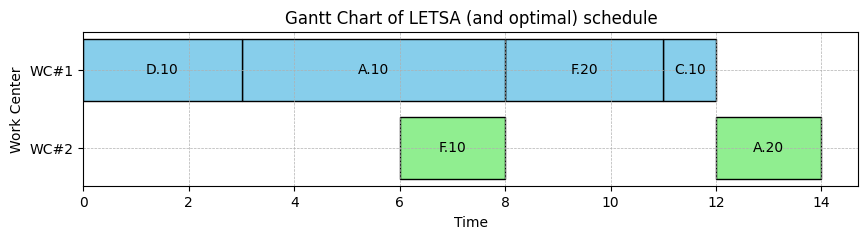

In [74]:
factory = load_factory()
operations = load_operations_from_df(df_BOM)
due_dates = load_due_dates(df_BOM)
scheduled_operations = schedule_operations(operations, due_dates, factory)

# # Plot Gantt chart
plot_gantt_chart(scheduled_operations)

### Debug

In [56]:
def check_availability(time, machine_usage): 
    """
    Returns True if the time interval does not overlap with any intervals in machine_usage, False otherwise.
        time            : (start, end)
        machine_usage   : [(0,3), (4,5)]
    """
    start, end = time
    
    for interval in machine_usage:
        interval_start, interval_end = interval
        if not (end <= interval_start or start >= interval_end):
            return False
    
    return True

time = (1, 2)
machine_usage = [(0, 3), (4, 5)]
print(check_availability(time, machine_usage))  # Output: False

machine_usage = []
time = (3, 4)
print(check_availability(time, machine_usage))  # Output: True


def find_latest_start_time(completion_time, processing_time, machine_usage):
    """
    completion_time : float
    processing_time : float
    machine_usage   : list of tuples [(start1, end1), (start2, end2), ...]
    
    Returns the latest possible start time such that the job can be completed
    before the completion time and does not overlap with any intervals in machine_usage.
    """
    latest_start_time = completion_time - processing_time
    print(f"latest start time: {latest_start_time}")

    # Sort the machine usage intervals by their start times
    machine_usage = sorted(machine_usage, key=lambda x: x[0])
    print(machine_usage)

    # Iterate over the machine usage intervals in reverse order
    for interval in reversed(machine_usage):
        print(interval)
        interval_start, interval_end = interval
        
        # Check if there is a gap between the intervals where the job can fit
        if interval_end <= latest_start_time:
            if check_availability((latest_start_time, latest_start_time + processing_time), machine_usage):
                return latest_start_time
        latest_start_time = min(latest_start_time, interval_start - processing_time)
        print(f"current latest start time: {latest_start_time}")

    # Check if the latest possible start time is valid
    if check_availability((latest_start_time, latest_start_time + processing_time), machine_usage):
        return latest_start_time
    
    return None

# # Example usage
# completion_time = 10
# processing_time = 2
# machine_usage = [(0, 3), (4, 5), (7, 9)]
# print(find_latest_start_time(completion_time, processing_time, machine_usage))  # Output should be 5 or earlier

# completion_time = 13
# processing_time = 1
# machine_usage = []
# print(find_latest_start_time(completion_time, processing_time, machine_usage))  # Output should be 5 or earlier

completion_time = 13
processing_time = 1
machine_usage = [(0, 3), (4, 5), (7, 9)]
print(find_latest_start_time(completion_time, processing_time, machine_usage))  # Output should be 5 or earlier


False
True
latest start time: 12
[(0, 3), (4, 5), (7, 9)]
(7, 9)
12


In [ ]:
# MANUAL IMPLEMENTATION
def dfs(operations, current_op_id, path, path_length, all_paths):
    path.append(current_op_id)
    path_length += operations[current_op_id].processing_time
    
    if not operations[current_op_id].predecessors:
        all_paths.append((list(path), path_length))
    else:
        for pred in operations[current_op_id].predecessors:
            dfs(operations, pred, path, path_length, all_paths)
    
    path.pop()
    path_length -= operations[current_op_id].processing_time


def find_all_paths(operations, feasible_operations):
    for op_id in feasible_operations:
        all_paths = []
        dfs(operations, op_id, [], 0, all_paths)
    return all_paths


operations = load_operations_from_df(df_BOM)
for operation_key in operations.keys():
    print(f"{operations[operation_key].id} - successors: {operations[operation_key].successors}, predecessors: {operations[operation_key].predecessors}")
print("")


def update_F():
    F = [op_id for op_id, op in operations.items() if not op.scheduled and all(operations[succ_id].scheduled for succ_id in op.successors)]
    print(f"F: {F}")
    return F

F = update_F()
all_paths = find_all_paths(operations, F)
print(all_paths)
# for op_id, paths in all_paths_dict.items():
#     # print(f'Operation ID: {op_id}')
#     for path, length in paths:
#         print(f'Path: {path}, Total Length: {length}')
critical_path, critical_length = max(all_paths, key=lambda x:x[1])
print(critical_path, critical_length)
operation_selected = critical_path[0]
print(operation_selected)

# F = ['C.10', 'A.10']
# all_paths_dict = find_all_paths(operations, F)
# for op_id, paths in all_paths_dict.items():
#     # print(f'Operation ID: {op_id}')
#     for path, length in paths:
#         print(f'Path: {path}, Total Length: {length}')



In [ ]:
# # ITERATION 1
# F = update_F()
# critical_path, length = find_critical_path(operations, F)
# print(critical_path, length)
# operations['A.20'].scheduled = True

# # ITERATION 2
# F = update_F()
# critical_path, length = find_critical_path(operations, F)
# print(critical_path, length)


# F = ['C.10', 'A.10']
# critical_path, length = find_critical_path(operations, F)
# print(critical_path, length)

# due_dates = load_due_dates(df_BOM)

# # # # Schedule operations
# scheduled_operations = schedule_operations(operations, due_dates, factory)

# # # # Plot Gantt chart
# plot_gantt_chart(scheduled_operations)